In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

In [ ]:
#Converting Parquet data format to CSV
df_parquet_train = pd.read_parquet('train_essays.parquet')
df_parquet_train.to_csv('train_essays.csv')
df_parquet_train = pd.read_parquet('train_essays.parquet')
df_parquet_train.to_csv('train_essays.csv')
df_parquet_valid = pd.read_parquet('valid_essays.parquet')
df_parquet_valid.to_csv('valid_essays.csv')


# Newly Generated Data

We have obtained newly generated data from the Kaggle commpetition competitors who generted ne essay data using other LLMs, here is the link to the data source that we will be using for our own model creation. https://www.kaggle.com/datasets/conjuring92/ai-mix-v26



The inclusion of essays from both proprietary and open-source LLMs, along with human texts from varied sources, enriches the dataset with a broad spectrum of writing styles and complexities. This diversity is beneficial for training models that can generalize well across different types of text.

The dataset's incremental approach to addressing blind spots of previous generation models and enhancing robustness is critical. It suggests that the dataset has evolved to challenge models effectively, pushing for better detection methods of AI-generated text.

Utilizing the entire Persuade corpus and including human texts from various domains helps ensure that the model is well-trained in identifying nuances specific to human writing. This can be especially useful in fine-tuning models to be sensitive to subtle distinctions between human and LLM-generated essays.

The augmented essays introduce controlled noise and variations (e.g., spelling corrections, synonym replacements, obfuscations) to simulate potential attempts to evade detection by altering the text. Training models on such data can improve their resilience against evasion techniques and enhance their detection capabilities.

Experimenting with different generation configs (e.g., contrastive search, use of guidance scale) and prompting strategies enriches the dataset with a wide array of AI-generated text scenarios. This variety is invaluable for training models to recognize a range of generation patterns and techniques.

In [ ]:
df = pd.read_csv('train_essays.csv')
nltk.download('stopwords')


In [ ]:
df['generated'].value_counts()

# Data Preproccessing 

In [ ]:
# Cleaning Text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = text.strip()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    filtered_words = [word for word in tokens if word not in stopwords.words('english')]
    return " ".join(filtered_words)

df['text'] = df['text'].apply(lambda x: clean_text(x))

In [ ]:
df.to_csv("preprocessed_train_essays.csv")

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['generated'], test_size=0.2, random_state=42)


In [ ]:
X_train.to_csv("X_train_essays.csv")
X_test.to_csv("X_test_essays.csv")
y_train.to_csv("Y_train_essays.csv")
y_test.to_csv("Y_test_esssays.csv")


## TF-IDF and POS tagging

In [ ]:
# Text tokenization for RNN
tokenizer_text = Tokenizer(num_words=5000)
tokenizer_text.fit_on_texts(X_train)
X_train_seq = tokenizer_text.texts_to_sequences(X_train)
X_test_seq = tokenizer_text.texts_to_sequences(X_test)

# Determine a common maximum length for both word and POS sequences
common_max_length = max(max_length_text, max_length_pos)

# Pad both word and POS sequences to the common maximum length
X_train_padded = pad_sequences(X_train_seq, maxlen=common_max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=common_max_length, padding='post')
pos_input_train_padded = pad_sequences(pos_input_train, maxlen=common_max_length, padding='post')
pos_input_test_padded = pad_sequences(pos_input_test, maxlen=common_max_length, padding='post')

# TF-IDF Vectorization for Decision Tree
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf_train = tfidf_vectorizer.fit_transform(X_train)
X_tfidf_test = tfidf_vectorizer.transform(X_test)

In [ ]:
# POS Tagging and tokenization for RNN and Decision Tree
def create_pos_tag_sequences(texts):
    return [' '.join(tag for _, tag in pos_tag(word_tokenize(text))) for text in texts]

pos_tags_train = create_pos_tag_sequences(X_train)
pos_tags_test = create_pos_tag_sequences(X_test)

tokenizer_pos = Tokenizer()
tokenizer_pos.fit_on_texts(pos_tags_train)
pos_input_train = tokenizer_pos.texts_to_sequences(pos_tags_train)
pos_input_test = tokenizer_pos.texts_to_sequences(pos_tags_test)

max_length_pos = max(max(len(seq) for seq in pos_input_train), max(len(seq) for seq in pos_input_test))
pos_input_train_padded = pad_sequences(pos_input_train, maxlen=max_length_pos, padding='post')
pos_input_test_padded = pad_sequences(pos_input_test, maxlen=max_length_pos, padding='post')

# Combine TF-IDF and POS for Decision Tree
X_combined_train = hstack([X_tfidf_train, csr_matrix(pos_input_train_padded)])
X_combined_test = hstack([X_tfidf_test, csr_matrix(pos_input_test_padded)])

In [ ]:
#looking for unique POS Tags
from collections import Counter

def get_unique_pos_tags(texts):
    pos_counts = Counter()
    for text in texts:
        
        tags = nltk.pos_tag(nltk.word_tokenize(text))
        pos_counts.update(tag for word, tag in tags)
    return list(pos_counts.keys())

# Generate the list of unique POS tags from the training set
unique_pos_tags = get_unique_pos_tags(X_train)
print(f"Unique POS Tags: {unique_pos_tags}")


## Decision Tree Model Training


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_combined_train, y_train)
y_pred_dt = dt_model.predict(X_combined_test)
print(f'Decision Tree Model Accuracy: {accuracy_score(y_test, y_pred_dt)}')

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def evaluate_model(y_true, y_pred):
    metrics_dict = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='binary'),
        'recall': recall_score(y_true, y_pred, average='binary'),
        'f1_score': f1_score(y_true, y_pred, average='binary')
    }
    return metrics_dict


Evaluation Metrics:
Accuracy: 0.80
Precision: 0.88
Recall: 0.86
F1 Score: 0.87
[[ 2505  2327]
 [ 2610 16722]]


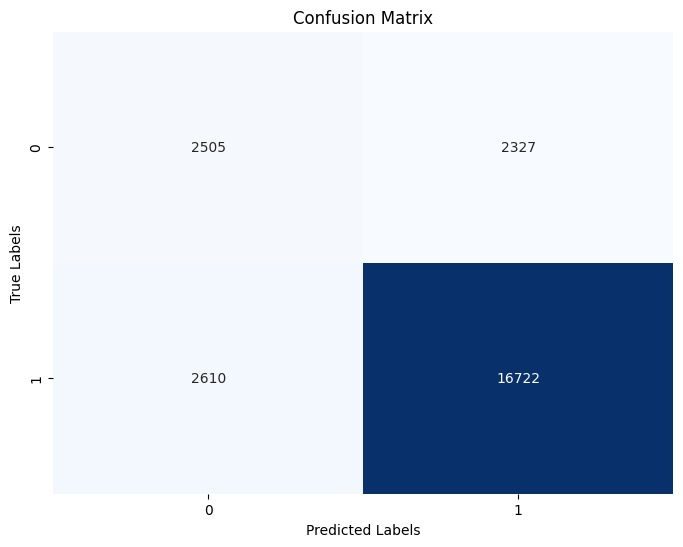

In [9]:
evaluation_results = evaluate_model(y_test, y_pred_dt)

# Print the evaluation results
print("Evaluation Metrics:")
print(f"Accuracy: {evaluation_results['accuracy']:.2f}")
print(f"Precision: {evaluation_results['precision']:.2f}")
print(f"Recall: {evaluation_results['recall']:.2f}")
print(f"F1 Score: {evaluation_results['f1_score']:.2f}")

conf_mat = confusion_matrix(y_test, y_pred_dt)
print(conf_mat)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## RNN Model Training

In [ ]:
# Define inputs 
word_input = Input(shape=(common_max_length,), dtype='int32', name="word_input")
pos_input = Input(shape=(common_max_length,), dtype='int32', name="pos_input")

# Embeddings
word_emb = Embedding(input_dim=len(tokenizer_text.word_index) + 1, output_dim=50, name="word_embedding")(word_input)
pos_emb = Embedding(input_dim=len(tokenizer_pos.word_index) + 1, output_dim=20, name="pos_embedding")(pos_input)

# Concatenate embeddings
conc_emb = Concatenate()([word_emb, pos_emb])

# RNN layers and output
x = Bidirectional(LSTM(64, return_sequences=True))(conc_emb)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(32))(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[word_input, pos_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit([X_train_padded, pos_input_train_padded], y_train, epochs=5, batch_size=64, validation_data=([X_test_padded, pos_input_test_padded], y_test))

_, rnn_accuracy = model.evaluate([X_test_padded, pos_input_test_padded], y_test)
print(f'RNN Model Accuracy: {rnn_accuracy}')

In [10]:
predictions_prob = model.predict([X_test_padded, pos_input_test_padded])
predictions = (predictions_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

evaluation_results = evaluate_model(y_test, predictions)

print("Evaluation Metrics:")
for metric, value in evaluation_results.items():
    print(f"{metric.capitalize()}: {value:.4f}")

756/756 [==============================] - 403s 518ms/step
Evaluation Metrics:
Accuracy: 0.8613
Precision: 0.8899
Recall: 0.9434
F1_score: 0.9159


# Simple Logistic Regression Revisited

Now with the new data, we will reun a simple logistic regression again since it seems that the first logistic regression model that we created on the initial dataset had data leakage

In [13]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_combined_train, y_train)

y_pred_lr = log_reg.predict(X_combined_test)

lr_evaluation_results = evaluate_model(y_test, y_pred_lr)

print("Logistic Regression Evaluation Metrics:")
for metric, value in lr_evaluation_results.items():
    print(f"{metric.capitalize()}: {value:.4f}")



Logistic Regression Evaluation Metrics:
Accuracy: 0.8044
Precision: 0.8226
Recall: 0.9633
F1_score: 0.8874


/Users/jaeswang/opt/anaconda3/envs/base2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Model Testing on Validation Data 

# Decision Tree

Decision Tree Evaluation Metrics:
Accuracy: 0.7957
Precision: 0.8778
Recall: 0.8650
F1_score: 0.8714
[[ 2505  2327]
 [ 2610 16722]]


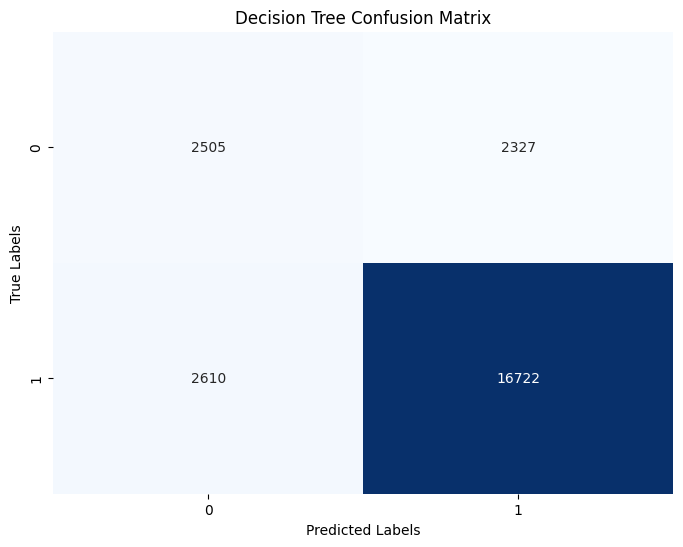

In [11]:
y_pred_dt = dt_model.predict(X_combined_test)

dt_evaluation_results = evaluate_model(y_test, y_pred_dt)

print("Decision Tree Evaluation Metrics:")
for metric, value in dt_evaluation_results.items():
    print(f"{metric.capitalize()}: {value:.4f}")

conf_mat_dt = confusion_matrix(y_test, y_pred_dt)
print(conf_mat_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_dt, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Decision Tree Confusion Matrix')
plt.show()


# RNN

In [12]:

predictions_prob = model.predict([X_test_padded, pos_input_test_padded])
predictions_rnn = (predictions_prob > 0.5).astype(int)

rnn_evaluation_results = evaluate_model(y_test, predictions_rnn)

print("RNN Model Evaluation Metrics:")
for metric, value in rnn_evaluation_results.items():
    print(f"{metric.capitalize()}: {value:.4f}")

_, rnn_accuracy = model.evaluate([X_test_padded, pos_input_test_padded], y_test)
print(f"RNN Model Accuracy: {rnn_accuracy:.4f}")


756/756 [==============================] - 341s 451ms/step
RNN Model Evaluation Metrics:
Accuracy: 0.8613
Precision: 0.8899
Recall: 0.9434
F1_score: 0.9159
756/756 [==============================] - 359s 475ms/step - loss: 0.3173 - accuracy: 0.8613
RNN Model Accuracy: 0.8613


# Number of Features

In [14]:
print(f"Vocabulary size (number of features for embeddings): {len(tokenizer_text.word_index) + 1}")


Vocabulary size (number of features for embeddings): 245771


In [16]:
print(f"Number of features in the combined training dataset for traditional models: {X_combined_train.shape[1]}")

print(f"Vocabulary size for neural networks (features in embeddings): {len(tokenizer_text.word_index) + 1}")


Number of features in the combined training dataset for traditional models: 6972
Vocabulary size for neural networks (features in embeddings): 245771
